### nsmc 및 hate 데이터셋 업로드

In [39]:
import pandas as pd

file_path_hate = "/jf-training-home/NLP_Model/datasets_rw/input/korean_hate_speech.tsv"
file_path_nsmc = "/jf-training-home/NLP_Model/datasets_rw/input/ratings_test.csv"

koreanHateSpeech = pd.read_csv(file_path_hate, delimiter='\t', encoding='utf-8')
nsmcData = pd.read_csv(file_path_nsmc, delimiter=',', encoding='utf-8')


### 사용할 컬럼만 놔두고 드랍

In [40]:
# 'label'이 1이고 결측치가 없는 행을 필터링하고 'label' 및 'id' 열을 삭제
shuffled_data = (
    nsmcData
    .dropna(subset=['label', 'id'])
    .assign(comments=lambda x: x['document'].astype(str))
    .reset_index(drop=True)
    .drop(columns=['id', 'document'])
    .rename(columns={'label': 'hate'})
)

# 결과 출력
print(shuffled_data['hate'].value_counts())


1    25173
0    24827
Name: hate, dtype: int64


In [41]:
hateLabelMap = {'none': 0, 'hate': 1, 'offensive': 1}

# 'comments'와 'hate' 컬럼을 남기고 나머지 컬럼은 제거
koreanHateSpeech = koreanHateSpeech[['comments', 'hate']].assign(hate=koreanHateSpeech['hate'].map(hateLabelMap))

# 'hate' 컬럼의 0과 1의 개수 출력
hate_counts = koreanHateSpeech['hate'].value_counts()
print("hate 컬럼의 0과 1의 개수:")
print(hate_counts)


hate 컬럼의 0과 1의 개수:
1    4410
0    3486
Name: hate, dtype: int64


### 텍스트 정제 

In [42]:
from util.text_cleaning import cleaning_text

shuffled_data['comments'] = shuffled_data['comments'].apply(cleaning_text)
print(shuffled_data)

       hate                                       comments
0         1                                             굳 
1         0                           gdntopclassintheclub
2         0             뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
3         0                      지루하지는 않은데 완전 막장임 돈주고 보기에는
4         0  3d만 아니었어도 별 다섯 개 줬을텐데 왜 3d로 나와서 제 심기를 불편하게 하죠
...     ...                                            ...
49995     1        오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
49996     0   의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 oooo
49997     0                그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다
49998     0     절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네
49999     0                                     마무리는 또 왜이래

[50000 rows x 2 columns]


In [43]:
koreanHateSpeech['comments'] = koreanHateSpeech['comments'].apply(cleaning_text)

### 데이터셋 병합

In [46]:
# koreanHateSpeech와 shuffled_data의 컬럼명을 통일
koreanHateSpeech = koreanHateSpeech.rename(columns={'comments': 'text', 'hate': 'label'})
shuffled_data = shuffled_data.rename(columns={'comments': 'text', 'hate': 'label'})

# 두 데이터셋을 합침
merged_data = pd.concat([koreanHateSpeech, shuffled_data], ignore_index=True)

# 결과 출력
print(merged_data['label'].value_counts())


1    29583
0    28313
Name: label, dtype: int64


### 훈련 및 테스트셋 분할

In [47]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    merged_data['text'].tolist(), merged_data['label'].tolist(), test_size=0.2, random_state=42
)

### 데이터셋 및 데이터 로더 생성

In [48]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


train_encodings = tokenizer.batch_encode_plus(
    train_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)
test_encodings = tokenizer.batch_encode_plus(
    test_texts, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)

### 모델, 옵티마이저, 손실 함수 정의 및 평가 함수

In [49]:
import torch
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 옵티마이저 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

### 데이터셋 및 데이터 로더 생성

In [51]:
from util.koreanHateSpeechDataset import KoreanHateSpeechDataset
from torch.utils.data import DataLoader

# 데이터셋 생성
train_dataset = KoreanHateSpeechDataset(train_encodings, train_labels)
test_dataset = KoreanHateSpeechDataset(test_encodings, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### 모델 학습 및 훈련

In [53]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from util.evaluate import evaluate
import torch.nn.functional as F

num_epochs = 10
losses = []
accuracies = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)
        optimizer.zero_grad()

        outputs = model(input_ids, labels=labels)
        loss =  F.cross_entropy(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    avg_loss = total_loss / len(train_loader)
    test_accuracy = evaluate(model, test_loader)
    accuracies.append(test_accuracy)
    losses.append(avg_loss)
    # 출력: 각 epoch에서의 accuracy와 loss
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 학습이 완료된 후 모델 저장
torch.save(model.state_dict(), '/jf-training-home/NLP_Model/src/models/checkpoints/model.pth')    



Epoch 2/10:   0%|          | 1/724 [00:00<01:37,  7.41it/s, loss=0.000565]

Epoch 1/10 - Loss: 0.5585, Test Accuracy: 0.7567


Epoch 3/10:   0%|          | 1/724 [00:00<01:28,  8.14it/s, loss=0.000603]

Epoch 2/10 - Loss: 0.4504, Test Accuracy: 0.7605


Epoch 4/10:   0%|          | 1/724 [00:00<01:28,  8.17it/s, loss=0.000555]

Epoch 3/10 - Loss: 0.3991, Test Accuracy: 0.7872


Epoch 5/10:   0%|          | 1/724 [00:00<01:23,  8.64it/s, loss=0.000444]

Epoch 4/10 - Loss: 0.3539, Test Accuracy: 0.7948


Epoch 6/10:   0%|          | 1/724 [00:00<01:23,  8.64it/s, loss=0.000234]

Epoch 5/10 - Loss: 0.3110, Test Accuracy: 0.7983


Epoch 7/10:   0%|          | 1/724 [00:00<01:24,  8.60it/s, loss=0.00026] 

Epoch 6/10 - Loss: 0.2699, Test Accuracy: 0.7907


Epoch 8/10:   0%|          | 1/724 [00:00<01:27,  8.22it/s, loss=0.000285]

Epoch 7/10 - Loss: 0.2325, Test Accuracy: 0.7949


Epoch 9/10:   0%|          | 1/724 [00:00<01:23,  8.62it/s, loss=0.000185]

Epoch 8/10 - Loss: 0.1954, Test Accuracy: 0.7919


Epoch 10/10:   0%|          | 1/724 [00:00<01:23,  8.61it/s, loss=8.22e-5]

Epoch 9/10 - Loss: 0.1712, Test Accuracy: 0.7934


Epoch 10/10 - Loss: 0.1418, Test Accuracy: 0.7928


Confusion Matrix:
[[4348 1301]
 [1098 4833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      5649
           1       0.79      0.81      0.80      5931

    accuracy                           0.79     11580
   macro avg       0.79      0.79      0.79     11580
weighted avg       0.79      0.79      0.79     11580



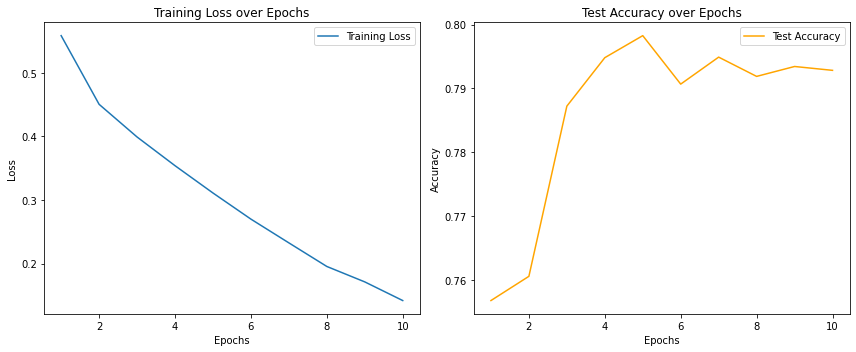

In [54]:
from sklearn.metrics import confusion_matrix, classification_report


# 테스트 데이터에서의 예측값과 실제값을 가져와서 혼동 행렬 계산
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 혼동 행렬 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 출력: 혼동 행렬과 성능 지표
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

# Plotting the loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()